# Table of Contents
* [Python Import](#Python-Import)
	* [2. Select Data Files](#2.-Select-Data-Files)
	* [3. Load the data](#3.-Load-the-data)
	* [4. Select Range of Image to Work On](#4.-Select-Range-of-Image-to-Work-On)
		* [a. Default Contrast  and Profile Range](#a.-Default-Contrast--and-Profile-Range)
		* [b. Image range](#b.-Image-range)
	* [5. Normalize data](#5.-Normalize-data)
	* [6. Select Profile Region](#6.-Select-Profile-Region)
	* [7. calculate profile over range of images](#7.-calculate-profile-over-range-of-images)
	* [8. Display global profile](#8.-Display-global-profile)
	* [9. Display Profile vs File Index](#9.-Display-Profile-vs-File-Index)
	* [10. Load file vs time stamp](#10.-Load-file-vs-time-stamp)
	* [11. Output profiles of previous image index selected](#11.-Output-profiles-of-previous-image-index-selected)
	* [12. Output profiles of all images](#12.-Output-profiles-of-all-images)


# Description

The user will select a profile region (rectangle). The pixels in the smallest width of the rectangle will be added. Then the profile ploted for each of the image index. This will allow for example to follow the flow of water as it enters a crack.

# Python Import

In [34]:
import custom_style
custom_style.style()

In [35]:
verbose = False
debugging = False
ipts_group = 'IPTS_16259'

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.gridspec as gridspec

%matplotlib inline

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re
from collections import OrderedDict

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from IPython.display import display
from IPython import display as display_ipython

import config_handler
import file_handler
import utilities
import gui_widgets
import time_utility

display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION: we are importing all \
        the python libraries</span>\
        <br><br><span style="font-size: 20px; color:blue"><b>Make sure you wait until a cell\
        is done executing before running another cell!</span>'))

font = {'family' : 'monospace',
       'size' : '14'}
mpl.rc('font', **font)

In [36]:
%gui qt

# Select Input Data Files

In [37]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (cell above): select the data files you want \
to analyze!</span>'))

root_folder = config_handler.load_config(key='root_folder', 
                                        default_value = 'HFIR/CG1D/{ipts}/raw/radiographs/'.format(ipts=ipts_group), 
                                        group = ipts_group)
list_data_files = gui_widgets.gui_fname(dir=root_folder,
                                       message = 'Select the Data Files ...',
                                       ext='tiff')

if list_data_files:
    config_handler.save_config(key='data_folder', value=os.path.dirname(list_data_files[0]), group=ipts_group)
    config_handler.save_config(key='root_folder', value=os.path.dirname(os.path.dirname(list_data_files[0])), group=ipts_group)

    list_data_files = np.sort(list_data_files)
    

# Loading Data 

In [39]:
w = widgets.IntProgress()
w.max = len(list_data_files)
display(w)
index = 0

array_images = []
for ref, file in enumerate(list_data_files):
    _image = file_handler.load_data(file)
    array_images.append(_image)
    index += 1
    w.value = index

# Select Range of Image to Work On 

In [47]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (cell below): \
Using the Image Index <i>image_index</i> slider, narrow down the range of images that \
we will use in the analysis. <br><br>Simply select where you see the water intake for the first time and write down its index. <br> \
Repeat with the last image to use in the calculation</span>'))


## Default Contrast  and Profile Range

30

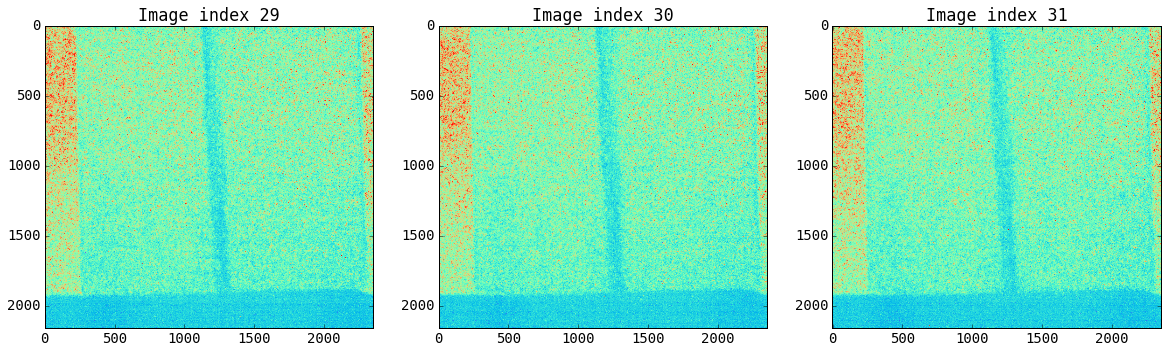

In [46]:
min_intensity = 82
max_intensity = 143

def plot_images(file_index):
    
    data_left = array_images[file_index-1]
    data      = array_images[file_index]
    data_right = array_images[file_index+1]
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1,3)
    
    ax_img = plt.subplot(gs[0,0])
    ax_img.imshow(data_left, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index-1))

    ax_img = plt.subplot(gs[0,1])
    ax_img.imshow(data, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
#    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    ax_img.set_title("Image index %d" %file_index)
    

    ax_img = plt.subplot(gs[0,2])
    ax_img.imshow(data_right, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index+1))
    
number_of_files = len(list_data_files)
range_selection = interact(plot_images,
                          file_index = widgets.IntSlider(min=1, 
                                                         max=number_of_files-2, 
                                                         value=8, 
                                                         step=1, 
                                                         description="Image Index"))


## Image range

In [48]:
display(HTML('<span style="font-size: 20px; color:blue">EXPLANATION (cell above): Using previous plot, \
define the <b>first image</b> and the <b>last time</b> to use in the analysis</span>'))

first_image_index = 8
last_image_index = 30

In [49]:
[image_height, image_width] = array_images[0].shape
working_array_images = array_images[first_image_index : last_image_index+1]
working_list_files = list_data_files[first_image_index : last_image_index+1]

# Normalize data

The data will be all normalized by using the first image. Each image will be divided by the first image.

In [50]:
normalization_image = list_data_files[0]
normalization_data = array_images[0]

_list_files = working_list_files

w = widgets.IntProgress()
w.max = len(_list_files)
display(w)
index = 0

normalized_array_images = []
for _image in working_array_images:
    _normalized_image = _image / normalization_data
    normalized_array_images.append(_normalized_image)
    index += 1
    w.value = index

Clear memory

In [51]:
del(array_images[:])
del(array_images)

# Select Profile Region 

default_profile_range

In [52]:
min_intensity = 0
max_intensity = 1

In [55]:
x_left = 1100
y_top = 0
width = 204
height = 2159

[1100, 0, 204, 2159, <matplotlib.figure.Figure at 0x1069680b8>]

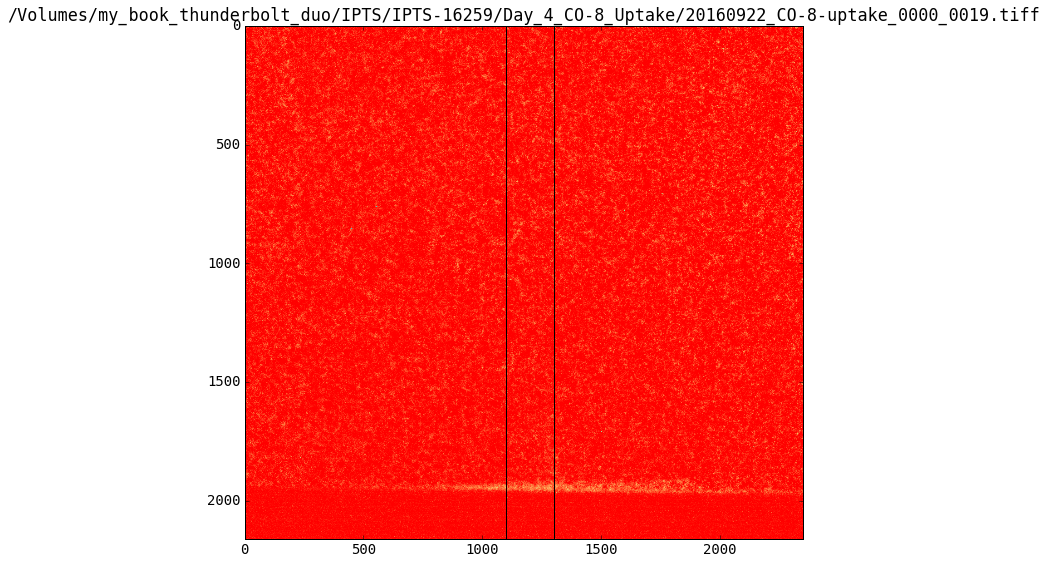

In [56]:
def plot_images_with_box(file_index, x_left, y_top, width, height):
    
    data = normalized_array_images[file_index][:, :]
    
    fig_box = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)
    
    ax_img.imshow(data, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    
    return [x_left, y_top, width, height, fig_box]

number_of_files = len(list_data_files)
profile = interact(plot_images_with_box,
                  file_index = widgets.IntSlider( min=0, max=len(working_list_files), 
                                                 value=0, step=1, 
                                                 description='Image index'),
                  x_left = widgets.IntSlider( min=0, max=image_width-1, step=1, value= x_left),
                  y_top = widgets.IntSlider( min=0, max=image_height-1, step=1, value= y_top), 
                  width = widgets.IntSlider( min=0, max=image_width-1, step=1, value= width), 
                  height = widgets.IntSlider( min=0, max=image_height-1, step=1, value=height))
    

# Calculate profile over range of images 

In [57]:
print(profile.widget.kwargs)
y_top = profile.widget.kwargs['y_top']
x_left = profile.widget.kwargs['x_left']
width = profile.widget.kwargs['width']
height = profile.widget.kwargs['height']

{'file_index': 0, 'x_left': 1100, 'y_top': 0, 'width': 204, 'height': 2159}


In [58]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0

profile_array = []
for _image in normalized_array_images:
    _profile_image = _image[y_top:y_top+height, x_left:x_left+width]
    _value = np.sum(_profile_image)
    profile_array.append(_value)
    w.value = index
    index += 1

# Display global profile 

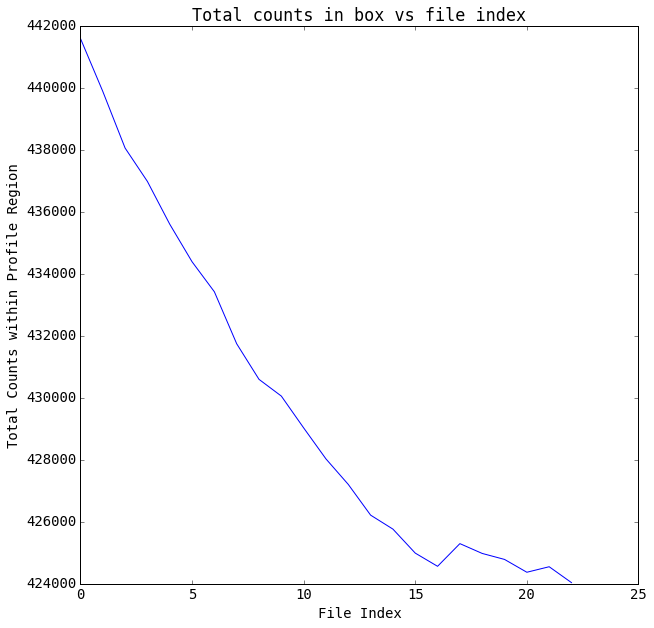

In [59]:
fig_profile = plt.figure(figsize=(10, 10))
plt.plot(profile_array)  
plt.title("Total counts in box vs file index")
plt.xlabel("File Index")
plt.ylabel("Total Counts within Profile Region")

# Display Profile vs File Index  

In order to improve the statitics, **rebin** allows to combine those pixels in the y-direction. 

In [60]:
rebin = 3  #number of pixels in y direction to rebin (to improve statistic)

Calculate the profile
 - rebin the pixels as defined by the **rebin** parameter along the y-axis
 - sum all the pixels along the x-axis

In [61]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0
rebin_range = np.arange(0, height-y_top, rebin)

profile_1d = []
def calculate_1d_profiles():
    
    for _index, _array in enumerate(normalized_array_images):
        _roi_array = _array[y_top:y_top+height, x_left:x_left+width]
        _width_profile = np.sum(_roi_array,1)
        rebin_width_profile = [sum(_width_profile[x:x+rebin]) for x in rebin_range]
        profile_1d.append(rebin_width_profile)
        _index += 1
        w.value = _index
    
calculate_1d_profiles()

6

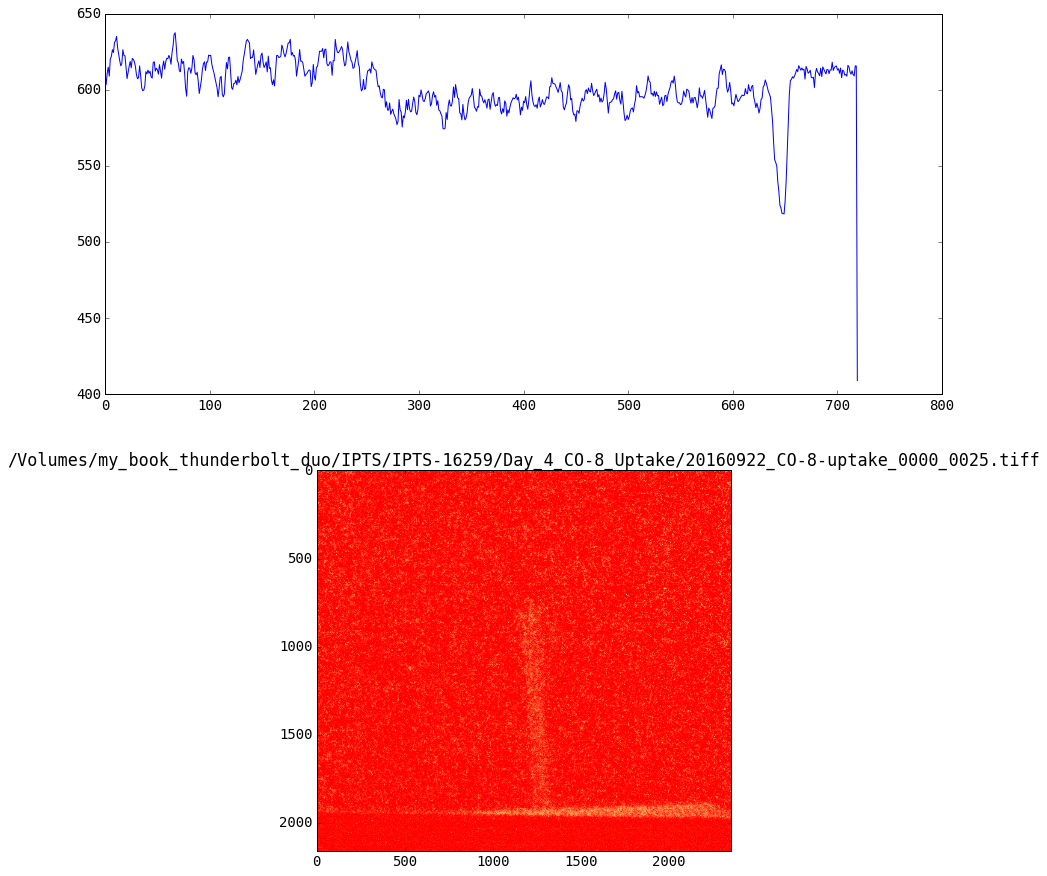

In [65]:
counts_max = 0
counts_min = 100

def plot_profile(file_index):
    
    data_1d = profile_1d[file_index]
    data_2d = normalized_array_images[file_index]
    
    fig = plt.figure(figsize=(15,15))
    
    plt.subplot(211)
    plt.plot(data_1d)
#    plt.ylim([counts_min, counts_max])
    
    ax_img = plt.subplot(212)
    ax_img.imshow(data_2d, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])
    
    return file_index

number_of_files = len(working_list_files)
range_selection = interact(plot_profile,
                          file_index = widgets.IntSlider(min=0, 
                                                         max=number_of_files-1, 
                                                         value=0, 
                                                         step=1, 
                                                         description="Image Index"))

# Load file vs time stamp 

In [67]:
file_vs_timestamp_file = gui_widgets.gui_fname(dir=root_folder,
                                              message='Select time_stamp_file created in step0',
                                              ext='txt')
if file_vs_timestamp_file:
    if type(file_vs_timestamp_file) == list:
        file_vs_timestamp_file = file_vs_timestamp_file[0]

    df = pd.read_csv(file_vs_timestamp_file)

In [68]:
df.head()

,#FileName,timeStamp_s,timeOffset_ms
0,20160922_CO-8-uptake_0000_0011.tiff,1.474569e+09,0.000000
1,20160922_CO-8-uptake_0000_0012.tiff,1.474569e+09,34.414530
2,20160922_CO-8-uptake_0000_0013.tiff,1.474569e+09,67.418098
3,20160922_CO-8-uptake_0000_0014.tiff,1.474569e+09,100.125790
4,20160922_CO-8-uptake_0000_0015.tiff,1.474569e+09,133.125782


In [69]:
list_file_name = df['#FileName'].values
list_column = df.columns.values
list_time_stamp = df[list_column[1]].values

# Output profiles of images selected

In [70]:
image_index = range_selection.widget.kwargs['file_index']
current_file = working_list_files[image_index]
current_profile = profile_1d[image_index]

In [71]:
[base_name, _ext] = os.path.splitext(os.path.basename(list_data_files[0]))
output_file_name = base_name + '_profiles.txt'
output_folder = config_handler.load_config(key='output_folder', group=ipts_group)
output_folder = gui_widgets.gui_dname(dir=output_folder,
                                     message = 'Select the output folder ...')
if output_folder:
    config_handler.save_config(key='output_folder', value=output_folder, group=ipts_group)
    
    ascii_file = os.path.join(output_folder, output_file_name)

In [72]:
ascii_file

'/Volumes/my_book_thunderbolt_duo/IPTS/IPTS-16259/profile_Day_4_CO-8_Uptake/20160922_CO-8-uptake_0000_0011_profiles.txt'

In [73]:
time_0 = list_time_stamp[first_image_index]

def create_ascii_contain(image_index):
    ascii_contain = []
    ascii_contain.append("#File display: {}\n".format(working_list_files[image_index]))
    ascii_contain.append("#ROI selected (y0,x0,height,width):({},{},{},{})\n".format(y_top, x_left, height, width))
    ascii_contain.append("#Rebin in y direction: {}\n".format(rebin))
    _time_stamp = list_time_stamp[image_index + first_image_index]
    _time_stamp_str = datetime.datetime.fromtimestamp(_time_stamp).strftime("%Y-%m-%d %H:%M:%S")
    ascii_contain.append("#Time stamp: {}\n".format(_time_stamp_str))
    _delta_time = _time_stamp - time_0
    ascii_contain.append("#Delta time (s): {}\n".format(_delta_time))
    ascii_contain.append("#\n")
    ascii_contain.append("#Label: pixel_index, counts\n")
    for index, value in enumerate(profile_1d[image_index]):
        ascii_contain.append("{}, {}\n".format(index, value))
    return ascii_contain

ascii_contain = create_ascii_contain(image_index)
if ascii_file:
    f = open(ascii_file, 'w')
    for _line in ascii_contain:
        f.write(_line)
    f.close()        

# Output profiles of all images

In [74]:
output_folder = gui_widgets.gui_dname(dir=output_folder,
                                     message = 'Select where to create all the images profile files ...')

In [75]:
def output_ascii_file(filename = None, data = None):
    f = open(filename, 'w')
    for _line in data:
        f.write(_line)
    f.close()

raw_file_name = 'profile1d_'
for _index, _profile in enumerate(profile_1d):
    output_file_name = os.path.join(output_folder, "raw_file_name_{:02}".format(_index) + '.txt')
    ascii_contain = create_ascii_contain(_index)
    output_ascii_file(filename = output_file_name, data = ascii_contain)